# Human Activity Recognition using TSFEL

On this example, we will perform Human Activity Recognition using our library **Time Series Feature Extraction Library**.

To perform this example every cell must be executed. To do so click run ([  ]) in the top left of every cell.

The first step consists of importing the library. To do that press play. 

The import can take a few seconds, but the run button will change so that you know the import has started and ended.

A warning will appear to reset all runtimes before running, click to accept.

In [1]:
#@title Import Time Series Feature Extraction Library
import warnings
warnings.filterwarnings('ignore')
!pip install https://github.com/fraunhoferportugal/tsfel/archive/v0.1.3-dev.tar.gz
!pip install pandas_profiling >/dev/null 2>&1
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip >/dev/null 2>&1

  Using cached https://github.com/fraunhoferportugal/tsfel/archive/v0.1.3-dev.tar.gz
  Created wheel for tsfel: filename=tsfel-0.1.3.dev0-cp37-none-any.whl size=42579 sha256=255391dd5644165c1d749850188500aa31c275099afbdddc12513acb9eff5c2d
  Stored in directory: /home/sara.santos/.cache/pip/wheels/e7/41/19/28f1943d234ff41dccbacb6f37d06b85f9e95c50a753906b1d
Successfully built tsfel


To check if everything was correctly imported, access "Files" (on the left side of the screen) and press "Refresh". If UCI HAR Dataset folder does not appear run Import Time Series Features library again.

---


In [2]:
# Import libraries
import secrets
import zipfile

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score

import tsfel
sns.set()

# Unzip dataset
zip_ref = zipfile.ZipFile("UCI HAR Dataset.zip", 'r')
zip_ref.extractall()
zip_ref.close()

# Dataset

The dataset we will be using is open-source. It is provided by UCI and it was performed by 30 volunteers using a smartphone on the waist. It contains 6 activities: 

*   Walking
*   Standing
*   Sitting
*   Laying
*   Upstairs
*   Downstairs

The dataset used in this example can be found [here](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones).




In [3]:
#@title Data Preparation
# Load train signals
total_accx_sig = np.loadtxt('UCI HAR Dataset/train/Inertial Signals/total_acc_x_train.txt')
total_accy_sig = np.loadtxt('UCI HAR Dataset/train/Inertial Signals/total_acc_y_train.txt')
total_accz_sig = np.loadtxt('UCI HAR Dataset/train/Inertial Signals/total_acc_z_train.txt')
body_gyrox_sig =np.loadtxt('UCI HAR Dataset/train/Inertial Signals/body_gyro_x_train.txt')
body_gyroy_sig = np.loadtxt('UCI HAR Dataset/train/Inertial Signals/body_gyro_y_train.txt')
body_gyroz_sig = np.loadtxt('UCI HAR Dataset/train/Inertial Signals/body_gyro_z_train.txt')

# Load test signals
total_accx_sigtest = np.loadtxt('UCI HAR Dataset/test/Inertial Signals/total_acc_x_test.txt')
total_accy_sigtest = np.loadtxt('UCI HAR Dataset/test/Inertial Signals/total_acc_y_test.txt')
total_accz_sigtest = np.loadtxt('UCI HAR Dataset/test/Inertial Signals/total_acc_z_test.txt')
body_gyrox_sigtest = np.loadtxt('UCI HAR Dataset/test/Inertial Signals/body_gyro_x_test.txt')
body_gyroy_sigtest = np.loadtxt('UCI HAR Dataset/test/Inertial Signals/body_gyro_y_test.txt')
body_gyroz_sigtest = np.loadtxt('UCI HAR Dataset/test/Inertial Signals/body_gyro_z_test.txt')

strain = np.vstack(([total_accx_sig.T], [total_accy_sig.T], [total_accz_sig.T], [body_gyrox_sig.T],
                                         [body_gyroy_sig.T], [body_gyroz_sig.T])).T

stest = np.vstack(([total_accx_sigtest.T], [total_accy_sigtest.T], [total_accz_sigtest.T], [body_gyrox_sigtest.T],
                                         [body_gyroy_sigtest.T], [body_gyroz_sigtest.T])).T

x_train_sig = [pd.DataFrame(strain[i], columns=['accx', 'accy', 'accz','gyrox', 'gyroy', 'gyroz'])
                for i in range(len(strain))]

x_test_sig = [pd.DataFrame(stest[i], columns=['accx', 'accy', 'accz','gyrox', 'gyroy', 'gyroz'])
                for i in range(len(stest))]

y_test = np.loadtxt('UCI HAR Dataset/test/y_test.txt')
y_train = np.loadtxt('UCI HAR Dataset/train/y_train.txt')
activity_labels = np.array(pd.read_csv('UCI HAR Dataset/activity_labels.txt', header=None, delimiter=' '))[:,1]

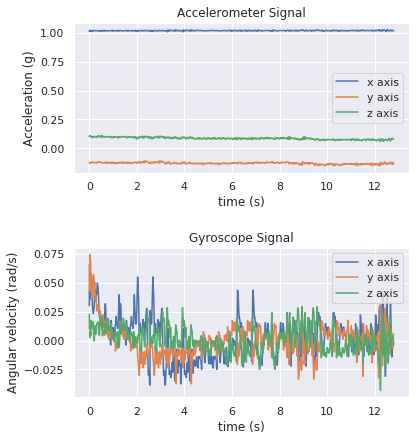

In [4]:
#@Signal Preview
%matplotlib inline
plt.figure()
plt.subplot(2,1,1)
plt_size = 10
acc_signal = np.concatenate(strain[:plt_size], axis=0)[:, :3]
time = np.linspace(0, len(acc_signal)/100, len(acc_signal))

plt.plot(time, acc_signal)
plt.xlabel("time (s)")
plt.ylabel("Acceleration (g)")
plt.title("Accelerometer Signal")
plt.legend(['x axis','y axis', 'z axis'])

plt.subplot(2,1,2)
gyro_signal = np.concatenate(strain[:plt_size], axis=0)[:,3:]
plt.plot(time, gyro_signal)
plt.xlabel("time (s)")
plt.ylabel("Angular velocity (rad/s)")
plt.title("Gyroscope Signal")
plt.legend(['x axis','y axis', 'z axis'])
plt.subplots_adjust(left=None, bottom=-0.3, right=None, top=1, wspace=None, hspace=0.5)

plt.show()

# Feature Extraction

Through **Feature Extraction** methodologies, the data is translated into a feature vector containing information about the signal properties of each window. These properties can be classified according to their domain as Time, Frequency and Statistical features and allow to characterise the signal compactly, enhancing its characteristics. This features will be used as input to the machine learning classifier, thus, the chosen set of features can strongly influence the classification output.

The features to extract are defined in the [google sheet](https://docs.google.com/spreadsheets/d/13u7L_5IX3XxFuq_SnbOZF1dXQfcBB0wR3PXhvevhPYA/edit?usp=sharing). Save a copy on your local drive and share it with featext@featext.iam.gserviceaccount.com.

**Change your google sheet file name and the googleSheet_name variable to your name so both have the same name.**

In [5]:
#@title Feature Extraction
googleSheet_name = "Features_dev"
# Extract excel info
cfg_file = tsfel.extract_sheet(googleSheet_name)

# Get features
X_train = tsfel.time_series_features_extractor(cfg_file, x_train_sig, fs=100)
X_test = tsfel.time_series_features_extractor(cfg_file, x_test_sig, fs=100)

This may take some time...
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


# Feature Selection

After the sensor data is extracted, redundancies and noise should be removed. Thus, minimising the algorithm's error, time and computational complexity. 

In [6]:
#@title Removal of highly correlated features

# Concatenation of entire data
features = pd.concat([X_train, X_test])
# Highly correlated features are removed
features = tsfel.correlation_report(features)

# Handling eventual missing values from the feature extraction
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.fillna(features.mean(), inplace=True)

# Normalising Features
min_max_scaler = preprocessing.MinMaxScaler()
nfeatures = pd.DataFrame(min_max_scaler.fit_transform(features.values), columns=features.columns, index=features.index)

nX_train = nfeatures[:len(X_train)]
nX_test = nfeatures[len(X_train):]

Do you wish to remove correlated features? Enter y/n: y
Removing accx_Spectral slope
Removing accx_Median
Removing accy_Median
Removing accz_Median
Removing gyrox_Median
Removing accx_Median absolute deviation
Removing accy_Median absolute deviation
Removing accz_Median absolute deviation
Removing gyrox_Median absolute deviation
Removing gyroy_Median absolute deviation
Removing gyroz_Median absolute deviation
Removing accx_Root mean square
Removing gyrox_Root mean square
Removing gyroy_Root mean square
Removing gyroz_Root mean square
Removing accx_Variance
Removing accy_Variance
Removing accx_Absolute energy
Removing accy_Absolute energy
Removing accz_Absolute energy
Removing gyroy_Absolute energy
Removing gyroz_Absolute energy
Removing accx_Mean absolute diff
Removing accy_Mean absolute diff
Removing gyrox_Mean absolute diff
Removing gyroz_Mean absolute diff
Removing accx_Median absolute diff
Removing accy_Median absolute diff
Removing accz_Median absolute diff
Removing gyrox_Median a

In [8]:
#@title Preview Features
st1 = pd.DataFrame(data=np.array(['c']*nX_train.shape[1]).reshape(1,-1), columns = list(features.columns))
st2 = pd.DataFrame(data=np.array([' ']*nX_train.shape[1]).reshape(1,-1), columns = list(features.columns))
feat_orange_header = pd.concat([st1, st2], axis=0, ignore_index=True)
_X_train = pd.concat([feat_orange_header, nX_train], axis=0, ignore_index=True)
_X_test = pd.concat([feat_orange_header, nX_test], axis=0, ignore_index=True)

labels = np.concatenate([y_train, y_test])
disc_labels = []
for l in labels:
  if l == 1:
    disc_labels.append('WALKING')
  elif l == 2:
    disc_labels.append('WALKING_UPSTAIRS')
  elif l == 3:
    disc_labels.append('WALKING_DOWNSTAIRS')
  elif l == 4:
    disc_labels.append('SITTING')
  elif l == 5:
    disc_labels.append('STANDING')
  elif l == 6:
    disc_labels.append('LAYING')
disc_y_train =  pd.DataFrame(data=disc_labels[:len(nX_train)], columns=['Activity'])
disc_y_test =  pd.DataFrame(data=disc_labels[len(nX_train):], columns=['Activity'])
disc_y_train = pd.concat([pd.DataFrame(data=['d','class'], columns=['Activity']), disc_y_train], axis=0, ignore_index=True)
disc_y_test = pd.concat([pd.DataFrame(data=['d','class'], columns=['Activity']), disc_y_test], axis=0, ignore_index=True)
orange_input_train= pd.concat([_X_train, disc_y_train], axis=1)
orange_input_test= pd.concat([_X_test, disc_y_test], axis=1)

orange_input_train.to_csv('orange_input_train.csv', sep=',', encoding='utf-8', index=False)
orange_input_test.to_csv('orange_input_test.csv', sep=',', encoding='utf-8', index=False)

nfeatures

,accx_Max power spectrum,accy_Max power spectrum,accz_Max power spectrum,gyrox_Max power spectrum,gyroy_Max power spectrum,gyroz_Max power spectrum,accx_Maximum frequency,accy_Maximum frequency,accz_Maximum frequency,gyrox_Maximum frequency,...,accz_Median diff,gyrox_Median diff,gyroy_Median diff,gyroz_Median diff,accx_Zero crossing rate,accy_Zero crossing rate,accz_Zero crossing rate,gyrox_Zero crossing rate,gyroy_Zero crossing rate,gyroz_Zero crossing rate
0,0.148629,0.204215,0.127450,0.391310,0.217828,0.118587,0.000000,0.218182,0.407407,0.600000,...,0.475383,0.513706,0.439492,0.474351,0.0,0.000000,0.000000,0.095238,0.066667,0.166667
1,0.173576,0.238150,0.271449,0.222691,0.390306,0.291534,0.000000,0.309091,0.407407,0.822222,...,0.478648,0.512413,0.439006,0.472196,0.0,0.000000,0.000000,0.119048,0.111111,0.404762
2,0.162511,0.391313,0.293913,0.312565,0.099319,0.295428,0.000000,0.309091,0.462963,0.755556,...,0.483037,0.515083,0.437653,0.473420,0.0,0.000000,0.000000,0.071429,0.044444,0.452381
3,0.071260,0.109693,0.232794,0.118995,0.272984,0.053093,0.000000,0.218182,0.425926,0.822222,...,0.475652,0.518135,0.440187,0.474113,0.0,0.000000,0.000000,0.142857,0.111111,0.333333
4,0.141275,0.115968,0.135260,0.125577,0.198499,0.202333,0.000000,0.236364,0.500000,0.777778,...,0.477972,0.512933,0.438528,0.474113,0.0,0.000000,0.000000,0.214286,0.288889,0.238095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2942,0.432871,0.370730,0.250453,0.329050,0.164752,0.268687,0.517857,0.654545,0.611111,0.800000,...,0.584810,0.511275,0.448500,0.383235,0.0,0.000000,0.111111,0.119048,0.422222,0.190476
2943,0.382677,0.430445,0.163270,0.410741,0.145901,0.878212,0.517857,0.763636,0.648148,0.688889,...,0.584810,0.483143,0.412095,0.453186,0.0,0.121212,0.111111,0.095238,0.511111,0.166667
2944,0.533266,0.305422,0.334560,0.245387,0.116864,0.490321,0.517857,0.709091,0.870370,0.822222,...,0.548674,0.460702,0.361818,0.540353,0.0,0.181818,0.083333,0.119048,0.466667,0.142857
2945,0.674476,0.407619,0.223219,0.390314,0.208609,0.529770,0.535714,0.618182,0.666667,0.600000,...,0.450727,0.475147,0.384375,0.532811,0.0,0.181818,0.166667,0.142857,0.377778,0.071429


# Classification

In this example the classification is performed with a [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) classifier.

In [9]:
classifier = RandomForestClassifier()

# Train the classifier
classifier.fit(nX_train, y_train.ravel())

# Predict test data
y_test_predict = classifier.predict(nX_test)

# Get the classification report
accuracy = accuracy_score(y_test, y_test_predict) *100
print(classification_report(y_test, y_test_predict))
print("Accuracy: " + str(accuracy) + '%')

              precision    recall  f1-score   support

         1.0       0.84      0.92      0.88       496
         2.0       0.87      0.84      0.86       471
         3.0       0.87      0.81      0.84       420
         4.0       0.85      0.89      0.87       491
         5.0       0.89      0.85      0.87       532
         6.0       1.00      1.00      1.00       537

   micro avg       0.89      0.89      0.89      2947
   macro avg       0.89      0.88      0.89      2947
weighted avg       0.89      0.89      0.89      2947

Accuracy: 88.83610451306413%


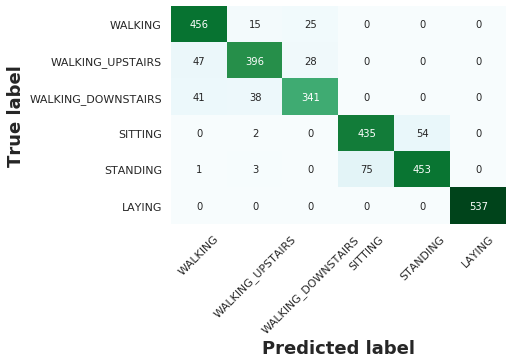

In [10]:
#@title Confusion Matrix
cm = confusion_matrix(y_test, y_test_predict)
df_cm = pd.DataFrame(cm, index=[i for i in activity_labels], columns=[i for i in activity_labels])
plt.figure()
ax= sns.heatmap(df_cm,  cbar=False, cmap="BuGn", annot=True, fmt="d")
plt.setp(ax.get_xticklabels(), rotation=45)

plt.ylabel('True label', fontweight='bold', fontsize = 18)
plt.xlabel('Predicted label', fontweight='bold', fontsize = 18)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

# Conclusion

As it can be seen in the confusion matrix, the misclassification was higher between WALKING UPSTAIRS vs WALKING DOWNSTAIRS vs WALKING and SITTING vs STANDING. Dynamic activities, due to their distinct motion characteristics and cyclic behaviour, were clearly discriminated against static activities.